# RefCOCO Dataset Exploration

**Goal:** Understand the RefCOCO dataset structure and characteristics for VLM boundary testing.

**Dataset:** lmms-lab/RefCOCO (lmms-eval format)
- 8,811 validation samples
- Multiple referring expressions per sample
- COCO images with ground truth bboxes

**Key decisions:**
1. How many samples for pilot/main experiments?
2. How to handle multiple expressions per sample?
3. What difficulty stratification to use?

In [1]:
# Fix imports after reorganization
import sys
sys.path.insert(0, 'scripts')

from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from collections import Counter
import sys

# Import our loader
from refcoco_loader import (
    load_refcoco,
    get_sample_info,
    compute_bbox_difficulty,
    get_balanced_subset
)

sns.set_style('whitegrid')
np.random.seed(42)

## 1. Load Dataset

In [2]:
# Load full validation set
print("Loading RefCOCO validation set...")
dataset = load_refcoco('val')

print(f"\nTotal samples: {len(dataset)}")
print(f"Features: {list(dataset.features.keys())}")

# Check first sample
sample_0 = get_sample_info(dataset[0])
print(f"\nSample 0:")
print(f"  Image size: {sample_0['image_size']}")
print(f"  Bbox (normalized): {sample_0['bbox_normalized']}")
print(f"  Expressions: {len(sample_0['expressions'])}")
for i, expr in enumerate(sample_0['expressions'][:3]):
    print(f"    [{i}] {expr}")

Loading RefCOCO validation set...

Total samples: 8811
Features: ['question_id', 'image', 'question', 'answer', 'segmentation', 'bbox', 'iscrowd', 'file_name']

Sample 0:
  Image size: (640, 428)
  Bbox (normalized): [0.73171873 0.00212617 0.99999998 0.27343459]
  Expressions: 4
    [0] bowl behind the others can only see part
    [1] Dish in top right corner
    [2] White dish in the top right corner.


## 2. Dataset Statistics

In [3]:
# Analyze bbox sizes and expression characteristics
bbox_widths = []
bbox_heights = []
bbox_areas = []
num_expressions = []
expression_lengths = []
difficulties = []

print("Analyzing dataset...")
for sample in dataset:
    bbox = sample['bbox']
    img_size = sample['image'].size
    
    x, y, w, h = bbox
    img_w, img_h = img_size
    
    # Normalized bbox dimensions
    bbox_widths.append(w / img_w)
    bbox_heights.append(h / img_h)
    bbox_areas.append((w * h) / (img_w * img_h))
    
    # Expression statistics
    expressions = sample['answer']
    num_expressions.append(len(expressions))
    for expr in expressions:
        expression_lengths.append(len(expr.split()))
    
    # Difficulty
    difficulties.append(compute_bbox_difficulty(bbox, img_size))

# Convert to numpy
bbox_widths = np.array(bbox_widths)
bbox_heights = np.array(bbox_heights)
bbox_areas = np.array(bbox_areas)
num_expressions = np.array(num_expressions)
expression_lengths = np.array(expression_lengths)

print(f"\nBbox Statistics (normalized):")
print(f"  Width:  mean={bbox_widths.mean():.3f}, std={bbox_widths.std():.3f}")
print(f"  Height: mean={bbox_heights.mean():.3f}, std={bbox_heights.std():.3f}")
print(f"  Area:   mean={bbox_areas.mean():.3f}, std={bbox_areas.std():.3f}")

print(f"\nExpression Statistics:")
print(f"  Expressions per sample: mean={num_expressions.mean():.1f}, std={num_expressions.std():.1f}")
print(f"  Words per expression: mean={expression_lengths.mean():.1f}, std={expression_lengths.std():.1f}")

print(f"\nDifficulty Distribution:")
diff_counts = Counter(difficulties)
for diff in ['easy', 'medium', 'hard']:
    count = diff_counts[diff]
    print(f"  {diff.capitalize()}: {count} ({100*count/len(difficulties):.1f}%)")

Analyzing dataset...

Bbox Statistics (normalized):
  Width:  mean=0.356, std=0.184
  Height: mean=0.555, std=0.214
  Area:   mean=0.205, std=0.156

Expression Statistics:
  Expressions per sample: mean=2.8, std=0.4
  Words per expression: mean=3.5, std=2.1

Difficulty Distribution:
  Easy: 2337 (26.5%)
  Medium: 6294 (71.4%)
  Hard: 180 (2.0%)


## 3. Visualizations

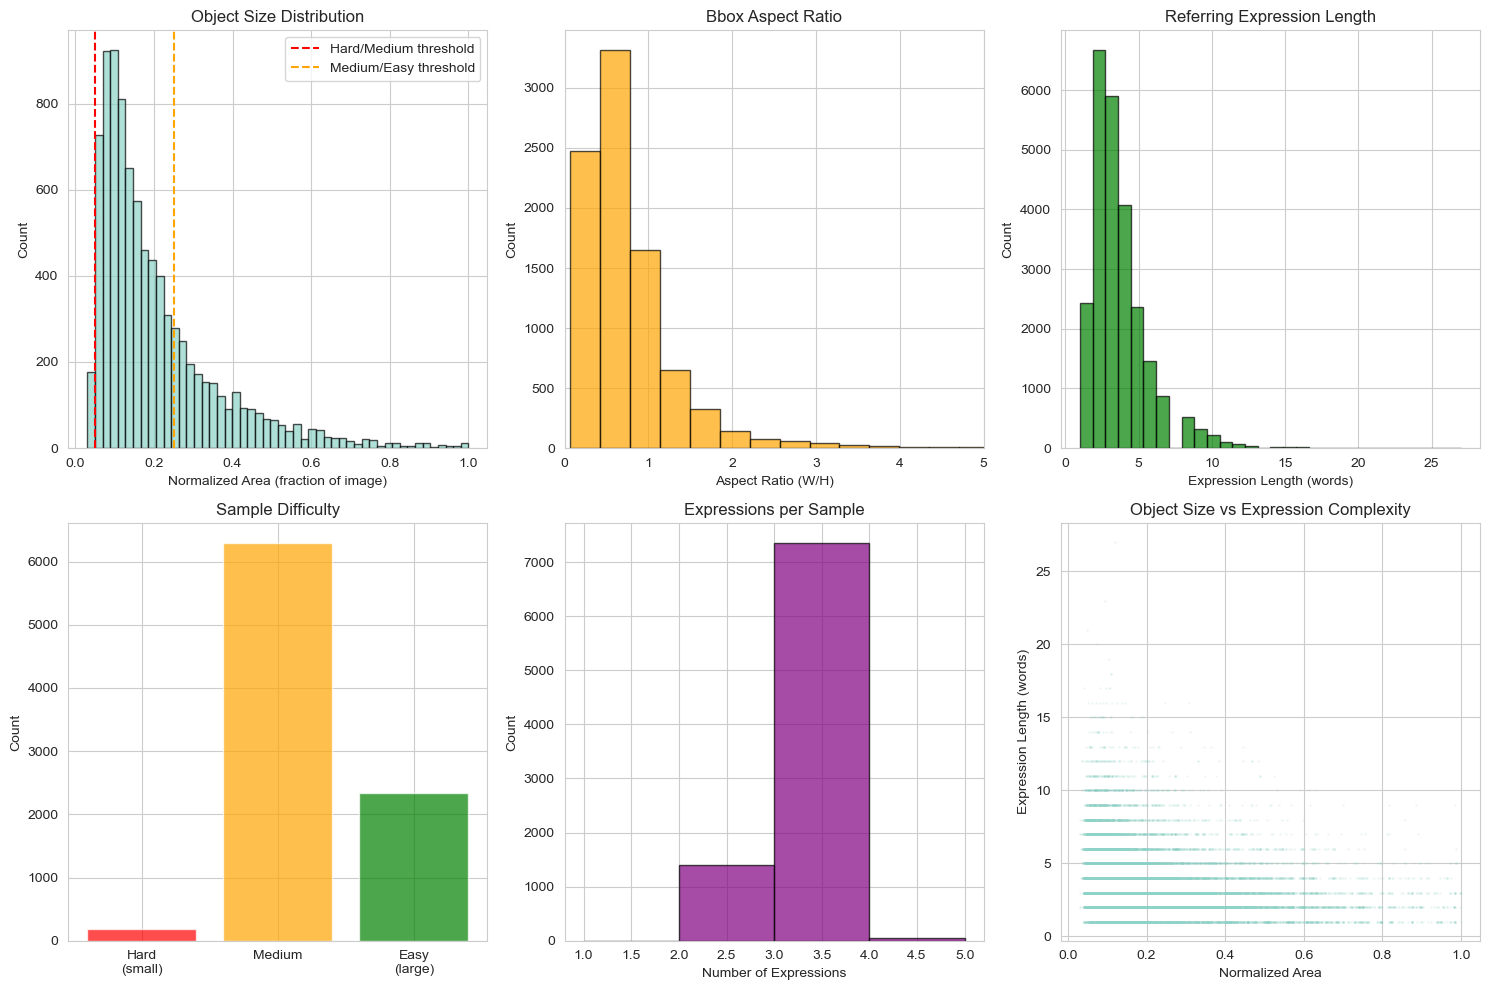

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Bbox area distribution
axes[0, 0].hist(bbox_areas, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0.05, color='red', linestyle='--', label='Hard/Medium threshold')
axes[0, 0].axvline(0.25, color='orange', linestyle='--', label='Medium/Easy threshold')
axes[0, 0].set_xlabel('Normalized Area (fraction of image)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Object Size Distribution')
axes[0, 0].legend()

# Aspect ratio
aspect_ratios = bbox_widths / bbox_heights
axes[0, 1].hist(aspect_ratios, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].set_xlabel('Aspect Ratio (W/H)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Bbox Aspect Ratio')
axes[0, 1].set_xlim(0, 5)

# Expression length
axes[0, 2].hist(expression_lengths, bins=30, alpha=0.7, edgecolor='black', color='green')
axes[0, 2].set_xlabel('Expression Length (words)')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Referring Expression Length')

# Difficulty distribution (bar chart)
diff_labels = ['Hard\n(small)', 'Medium', 'Easy\n(large)']
diff_values = [diff_counts['hard'], diff_counts['medium'], diff_counts['easy']]
axes[1, 0].bar(diff_labels, diff_values, color=['red', 'orange', 'green'], alpha=0.7)
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Sample Difficulty')

# Num expressions per sample
axes[1, 1].hist(num_expressions, bins=range(1, num_expressions.max()+2), alpha=0.7, edgecolor='black', color='purple')
axes[1, 1].set_xlabel('Number of Expressions')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Expressions per Sample')

# Area vs expression length
# Flatten: one point per expression
areas_per_expr = []
for i, sample in enumerate(dataset):
    for _ in sample['answer']:
        areas_per_expr.append(bbox_areas[i])

axes[1, 2].scatter(areas_per_expr, expression_lengths, alpha=0.1, s=1)
axes[1, 2].set_xlabel('Normalized Area')
axes[1, 2].set_ylabel('Expression Length (words)')
axes[1, 2].set_title('Object Size vs Expression Complexity')

plt.tight_layout()
plt.show()

## 4. Sample Visualization

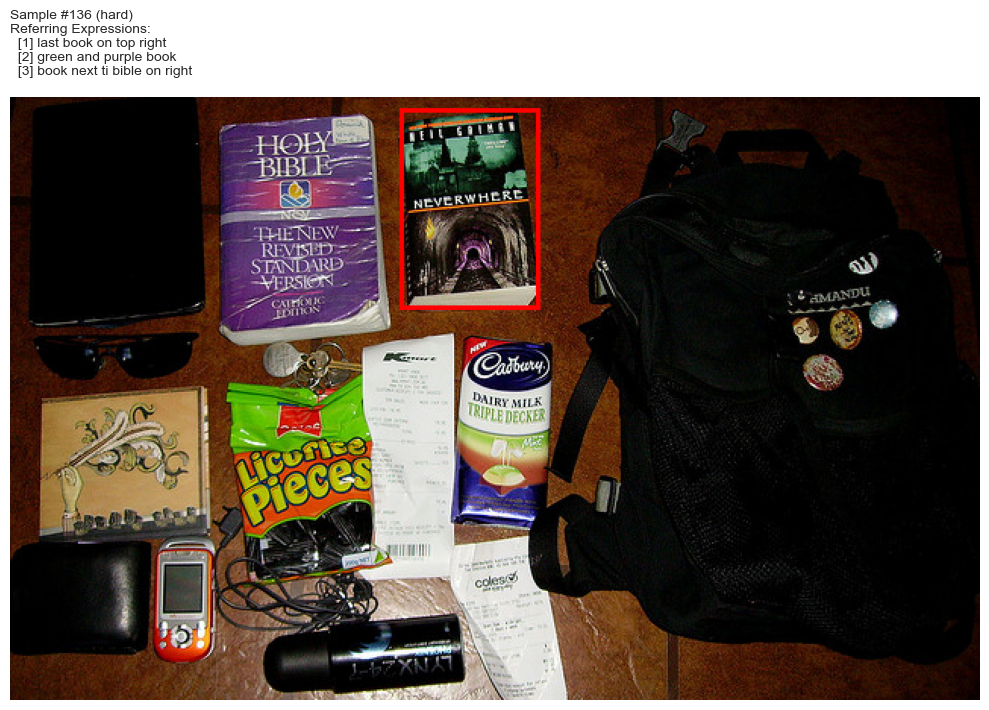

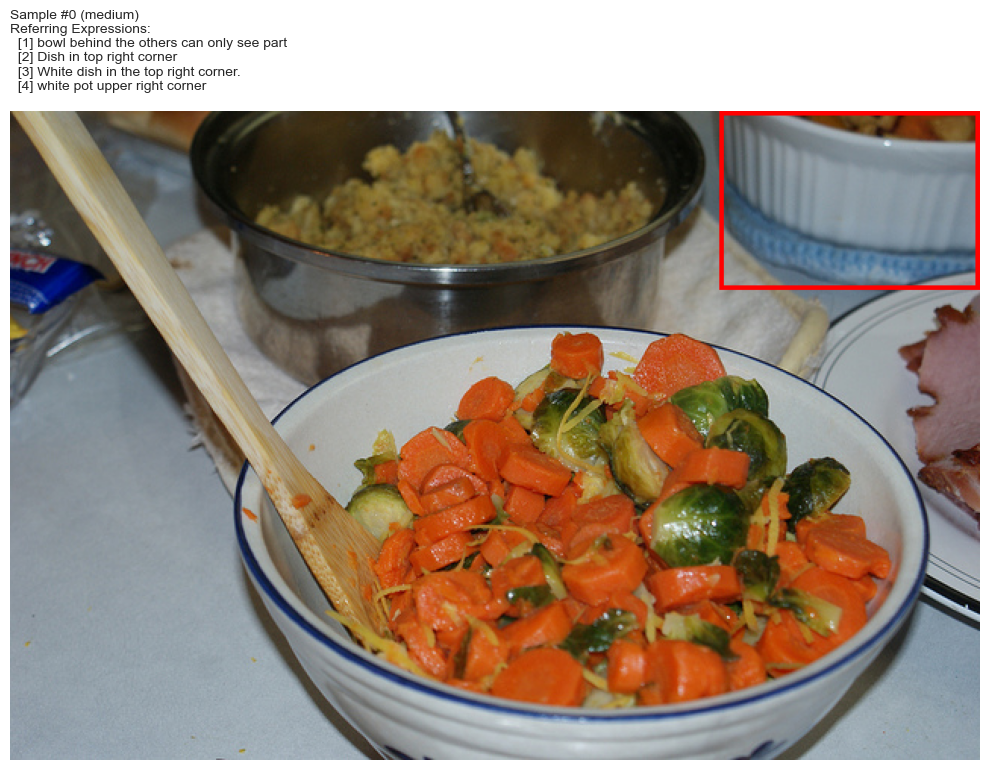

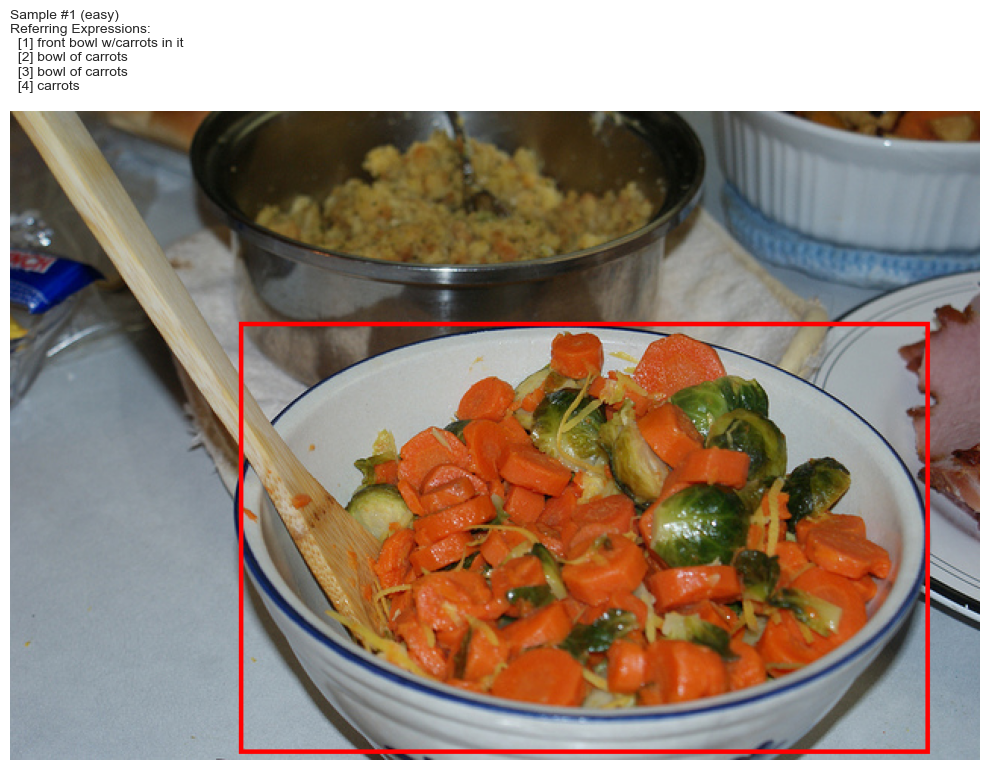

In [5]:
def visualize_refcoco_sample(sample_idx, dataset):
    """
    Visualize a RefCOCO sample with bbox and all referring expressions.
    """
    sample = dataset[sample_idx]
    info = get_sample_info(sample)
    
    # Draw bbox on image
    img = info['image'].copy()
    draw = ImageDraw.Draw(img)
    
    x, y, w, h = info['bbox_pixels']
    bbox_rect = [x, y, x + w, y + h]
    draw.rectangle(bbox_rect, outline='red', width=3)
    
    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    
    # Title with all expressions
    difficulty = compute_bbox_difficulty(info['bbox_pixels'], info['image_size'])
    title = f"Sample #{sample_idx} ({difficulty})\n"
    title += "Referring Expressions:\n"
    for i, expr in enumerate(info['expressions']):
        title += f"  [{i+1}] {expr}\n"
    
    plt.title(title, fontsize=10, loc='left')
    plt.tight_layout()
    plt.show()

# Show examples from each difficulty
for diff in ['hard', 'medium', 'easy']:
    # Find first sample with this difficulty
    idx = difficulties.index(diff)
    visualize_refcoco_sample(idx, dataset)

## 5. Create Test Subsets

Based on literature review:
- **Pilot:** 10 samples (feasibility check)
- **Small-scale:** 50 samples (threshold optimization)
- **Validation:** 100 samples (final results)

In [6]:
# Create balanced subsets
pilot_indices = get_balanced_subset(dataset, n_per_difficulty=3)  # 9 samples
small_indices = get_balanced_subset(dataset, n_per_difficulty=17) # ~50 samples
validation_indices = get_balanced_subset(dataset, n_per_difficulty=33) # ~100 samples

print(f"Pilot subset: {len(pilot_indices)} samples")
print(f"Small-scale subset: {len(small_indices)} samples")
print(f"Validation subset: {len(validation_indices)} samples")

# Save indices for reuse
np.save('pilot_subset_indices.npy', np.array(pilot_indices))
np.save('small_subset_indices.npy', np.array(small_indices))
np.save('validation_subset_indices.npy', np.array(validation_indices))

print(f"\nSaved subset indices to .npy files")
print(f"\nPilot subset difficulty distribution:")
pilot_diffs = [difficulties[i] for i in pilot_indices]
for diff in ['easy', 'medium', 'hard']:
    count = pilot_diffs.count(diff)
    print(f"  {diff.capitalize()}: {count}")

Pilot subset: 9 samples
Small-scale subset: 51 samples
Validation subset: 99 samples

Saved subset indices to .npy files

Pilot subset difficulty distribution:
  Easy: 3
  Medium: 3
  Hard: 3


## 6. Expression Analysis

Understand referring expression patterns.

In [7]:
# Common words in referring expressions
all_words = []
for sample in dataset:
    for expr in sample['answer']:
        all_words.extend(expr.lower().split())

word_counts = Counter(all_words)

print(f"Total words: {len(all_words):,}")
print(f"Unique words: {len(word_counts):,}")
print(f"\nMost common words (top 30):")
for word, count in word_counts.most_common(30):
    print(f"  {word:15s}: {count:5d}")

Total words: 88,915
Unique words: 4,481

Most common words (top 30):
  left           :  5771
  right          :  5397
  on             :  4526
  in             :  3612
  the            :  3403
  guy            :  2035
  man            :  1943
  shirt          :  1547
  of             :  1456
  person         :  1413
  front          :  1354
  white          :  1281
  with           :  1250
  bottom         :  1207
  woman          :  1157
  top            :  1151
  middle         :  1086
  girl           :  1025
  red            :   971
  black          :   964
  blue           :   952
  far            :   924
  to             :   843
  back           :   795
  from           :   767
  chair          :   523
  center         :   472
  elephant       :   460
  kid            :   458
  lady           :   456


## Summary & Next Steps

### Key Findings:
1. **Dataset size:** 8,811 validation samples (sufficient)
2. **Multiple expressions:** ~3-4 per sample (use first one for consistency)
3. **Difficulty distribution:** Check actual percentages above
4. **Expression length:** Typically 3-8 words

### Decisions for Experiments:
1. **Pilot (10 samples):** Test VLM capability & perturbation sensitivity
2. **Small-scale (50 samples):** Optimize thresholds
3. **Validation (100 samples):** Final results & statistical validation

### Expression Selection Strategy:
- **Option A:** Use first expression only (simplest)
- **Option B:** Test all expressions, aggregate results
- **Recommendation:** Start with Option A, validate with Option B if time permits

### Next Notebook:
→ **02_threshold_optimization.ipynb** - Apply to RefCOCO data